# Running SQL queries in Jupyter: A "magical" Adventure with JupySQL

Read this notebook if you're looking for answers to one or both of the following -
1. I have a humongos dataset that won't fit into my computer's memory.
2. I have a smallish datatset but am still running out of memory after applying several transformations.

TL;DR:
[JupySQL](https://github.com/ploomber/jupysql) to the rescue! You can now run SQL queries easily on the database server and plot results on your local machine with minimal code (and memory) overhead. 



## Can't I use pandas?
Pandas was my go-to choice for data manipulation and analysis throughout school life. Those were the days when the datasets would neatly fit on my computer and needed minimal cleaning/transformations. But as the cliche goes, the industry is a very different world where the opposite is often true. Tasks involving heavy data cleaning and transformations is routine where in you might start with a dataset that fits in memory but after several operations blows up the memory, or you need to work with a dataset that refuses to fit into memory in the first place.  


<img src="jupysql-matrix.png" alt="Matrix" style="width: 500px;"/>

The bottom-left corner of the matrix is where you're in the blissful world of pandas. Everyone else, meet your new friend JupySQL! Using SQL magic functions, you can analyze and plot data with minimal code ✨

But I already have a friend and her name is SQLAlchemy you say? If you want to create plots from your data, SQLAlchemy can really make you work for it, as you will see in a bit. 


Let's compare pandas and JupySQL by taking a look at a simple query and some simple plots on [NYC taxi data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This dataset contains ~1.4 million rows and 19 columns.

Let's check out pandas first...

## SQL querying with pandas

In [3]:
%pip install pandas pandasql pyarrow --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
from pathlib import Path
from urllib.request import urlretrieve
import os

url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet"

if not Path("yellow_tripdata_2021-01.parquet").is_file():
    urlretrieve(url, "yellow_tripdata_2021-01.parquet")
    os.rename("yellow_tripdata_2021-01.parquet", "yellow_tripdata_2021.parquet")

Let's keep a check on memory used as we go. We'll use the %memit magic function for this.

In [23]:
%pip install line-profiler --quiet
%load_ext memory_profiler

Note: you may need to restart the kernel to use updated packages.
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [6]:
import pandas as pd
from pandasql import sqldf

In [7]:
%memit df = pd.read_parquet("./yellow_tripdata_2021.parquet")

peak memory: 585.66 MiB, increment: 454.79 MiB


In [8]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN


In [9]:
%%memit
# This query computes the total and average amount spent based on the number of passengers in a taxi
query = "SELECT DISTINCT passenger_count, ROUND(SUM(fare_amount), 0) as TotalFares, ROUND(AVG(fare_amount), 0) as AvgFares from df GROUP BY passenger_count ORDER BY AvgFares DESC"
result = sqldf(query)

peak memory: 3307.89 MiB, increment: 2721.77 MiB


As you can see, the memory consumed in the above operation is many times higher than the file size. Pandas is notorious for having high memory overheads that can result in Out-of-memory (OOM) issues for even medium sized datasets.

In [10]:
display(result)

,passenger_count,TotalFares,AvgFares
0,7.0,298.0,60.0
1,NaN,2565865.0,26.0
2,4.0,191410.0,12.0
3,8.0,22.0,11.0
4,6.0,270645.0,11.0
5,5.0,342763.0,11.0
6,3.0,497113.0,11.0
7,2.0,1851011.0,11.0
8,1.0,10556091.0,11.0
9,0.0,294371.0,11.0


Next, let's check out histogram plots with pandas ...

## Plotting with pandas

In [11]:
# Only keep fare amounts between 0 - 200
df = df[(df['fare_amount'] < 200) & (df['fare_amount'] > 0)]

peak memory: 624.38 MiB, increment: 27.10 MiB


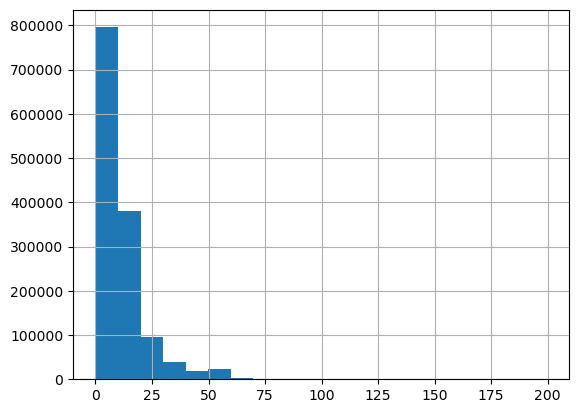

In [12]:
%memit df['fare_amount'].hist(bins=20)

## SQL querying with JupySQL's magic functions

Let's try the same SQL query and some plotting with JupySQL ...

We'll start by setting up a database engine. 

In [13]:
%pip install duckdb-engine jupysql --quiet
%load_ext sql
%sql duckdb://

Note: you may need to restart the kernel to use updated packages.


In [14]:
%%sql --save avg_fares
SELECT DISTINCT passenger_count, 
ROUND(SUM(fare_amount), 0) as TotalFares, 
ROUND(AVG(fare_amount), 0) as AvgFares from yellow_tripdata_2021.parquet 
GROUP BY passenger_count 
ORDER BY AvgFares DESC

*  duckdb://
Done.


passenger_count,TotalFares,AvgFares
7.0,298.0,60.0
None,2565865.0,26.0
4.0,191410.0,12.0
1.0,10556091.0,11.0
0.0,294371.0,11.0
2.0,1851011.0,11.0
3.0,497113.0,11.0
5.0,342763.0,11.0
6.0,270645.0,11.0
8.0,22.0,11.0


In order to check memory consumption, since jupyter does not allow multiple magic functions in the same cell, let's wrap it around a function. 

In [18]:
def time_my_query():
    query = f'''SELECT DISTINCT passenger_count, 
            ROUND(SUM(fare_amount), 0) as TotalFares, 
            ROUND(AVG(fare_amount), 0) as AvgFares from yellow_tripdata_2021.parquet 
            GROUP BY passenger_count 
            ORDER BY AvgFares DESC'''
    get_ipython().run_cell_magic('sql', '', query)

In [19]:
%memit time_my_query()

*  duckdb://
Done.
peak memory: 629.00 MiB, increment: 0.13 MiB


Local memory was barely used.

*Bonus*:
Surprised by this voodoo magic? The SQL engine frees up memory by getting rid of unnecessary data copies after execution, which you'll have to do manually in pandas. It is also much faster than the pandas execution.

## Plotting with JupySQL

<AxesSubplot:title={'center':"'fare_amount' from 'yellow_tripdata_2021.parquet'"}, ylabel='fare_amount'>

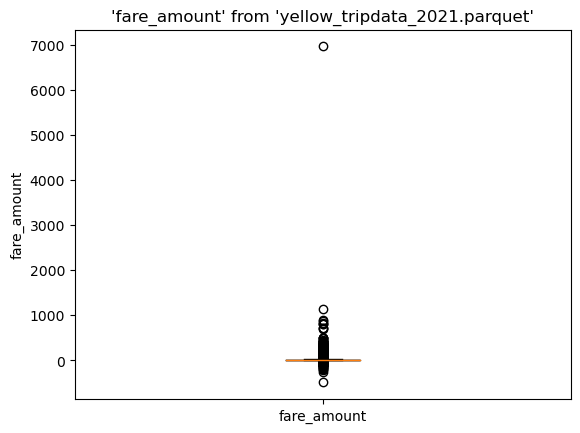

In [20]:
%sqlplot boxplot --table yellow_tripdata_2021.parquet --column fare_amount

In [21]:
%%sql --save taxi_filtered --no-execute
SELECT * FROM yellow_tripdata_2021.parquet 
WHERE fare_amount < 200 
AND fare_amount > 0

*  duckdb://
Skipping execution...


<AxesSubplot:title={'center':"'fare_amount' from 'taxi_filtered'"}, xlabel='fare_amount', ylabel='Count'>

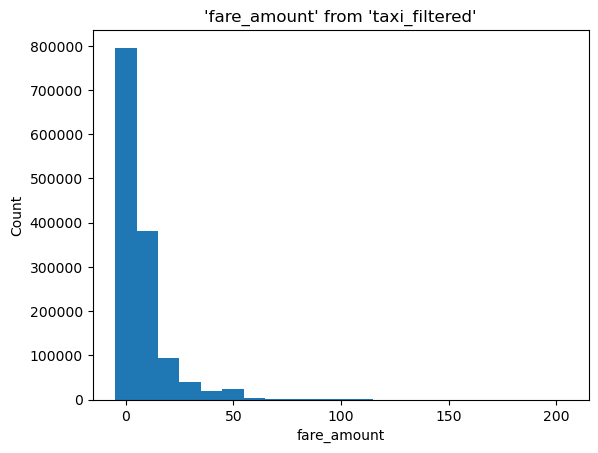

In [24]:
%sqlplot histogram --column fare_amount --bins 20 --table taxi_filtered --with taxi_filtered

JupySQL provides lightweight and easy to use plotting functions that work and look similar to matplotlib. 

... But why can't I use my friend SQLAlchemy? 
Well you could very well use it, but it does not provide easy to use and memory efficient visualization functions. You'll need to either: 
- Use matplotlib/seaborn which require loading the data into memory (back to square one with the memory issue)
- Or write SQL code that runs on the server side to compute the statistics that these plotting functions perform under the hood, such as computing the percentiles for box plot, bin counts for histogram plot etc., and feed the summarized statistics to matplotlib/seaborn. For example, for the above histrogram plot, you'll need to write an SQL query that creates 20 bins and computes the respective counts on the server side. The 20 bins and their values can then be loaded up into local memory to create a bar plot. That's exactly what JupySQL does for you!

It's your turn! Pick your poison wisely - alchemy or magic? 